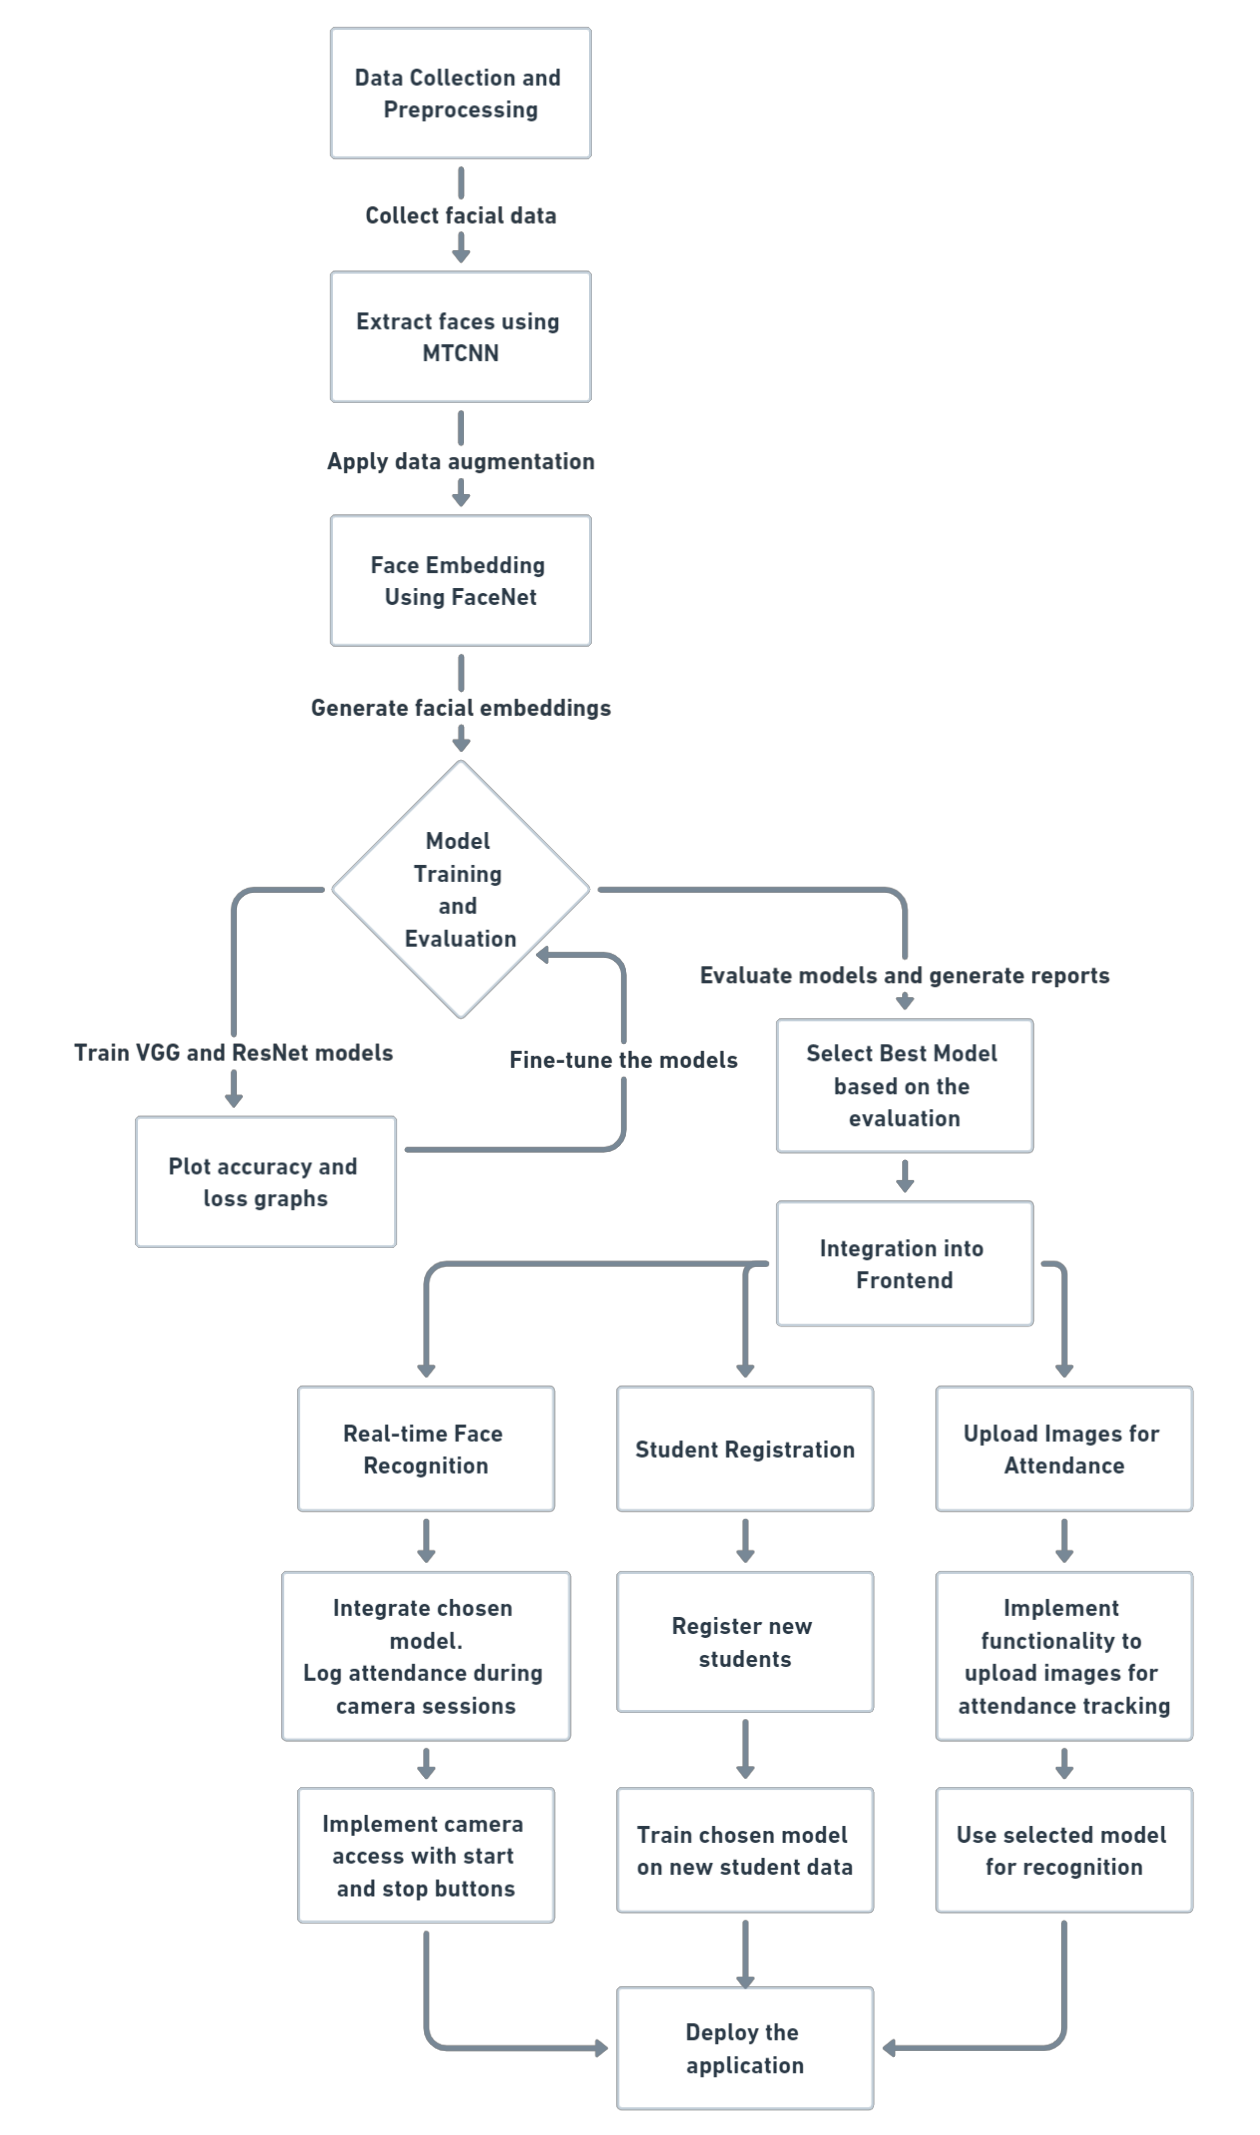


### **Research Question:**
**How can deep learning models, specifically ResNet and VGG, be effectively employed to develop an accurate and efficient face recognition system for real-time attendance management?**

# Import Libraries

In [ ]:
import os
import numpy as np
from PIL import Image
from mtcnn import MTCNN
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model

# Data Loading & Face extraction

In [ ]:
#  Preprocess images and extract faces using MTCNN
def extract_faces_with_augmentation(images_folder, datagen=None):
    detector = MTCNN()
    face_data = []
    labels = []
    for image_name in os.listdir(images_folder):
        img_path = os.path.join(images_folder, image_name)
        print(image_name)
        image = Image.open(img_path)
        faces = detector.detect_faces(np.array(image))
        if len(faces) > 0:
            x, y, w, h = faces[0]['box']
            face = image.crop((x, y, x+w, y+h)).resize((160, 160))
            if datagen is not None:  
                for _ in range(20): 
                    augmented_faces = datagen.flow(np.array(face).reshape(1, 160, 160, 3), batch_size=1).next()
                    for augmented_face in augmented_faces:
                        face_data.append(np.array(augmented_face))
                        labels.append(image_name.split('.')[0])
            else: 
                face_data.append(np.array(face))
                labels.append(image_name.split('.')[0])
    return np.array(face_data), labels

# Paths to training and testing image folders
train_folder = "dataset/train_set"
test_folder = "dataset/test_set"
# Create data augmentation generator for training data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.75, 1.25],
    fill_mode='nearest'
)

# Extract faces with data augmentation for training images
print("Extract faces & apply data augmentation for training images:")
train_images, train_labels = extract_faces_with_augmentation(train_folder, datagen)

# Plot training images

In [ ]:
#Verify and ploting the training augmented images with labels
# Calculate the number of rows and columns for the subplot grid
num_images = len(train_images)
num_columns = 5
num_rows = (num_images + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 200))
for i, ax in enumerate(axes.flatten()):
    if i < num_images:
        image = train_images[i].astype(np.uint8)  # Convert image to uint8
        ax.imshow(image,cmap='gray')
        ax.set_title("Train Image: " + train_labels[i], fontsize=8)
        ax.axis("off")
    else:
        ax.axis("off")
plt.tight_layout()
plt.show()

# Face Embeddings

In [ ]:
#  Get embeddings using Google Facenet
def get_face_embeddings(facenet_model, face_images):
    embeddings = []
    for face_image in face_images:
        img = tf.image.resize(face_image, (160, 160))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0  # Normalize pixel values to [0, 1]
         # Use facenet_model to predict embeddings
        embedding = facenet_model.predict(img) 
        embeddings.append(embedding[0])
    return np.array(embeddings)
 
# Get face embeddings training images using Facenet
print("Get face embeddings training images using Facenet:")
# Load Facenet model
facenet_model_path = "models/facenet_keras.h5"
facenet_model = load_model(facenet_model_path) 
embeddings = get_face_embeddings(facenet_model, train_images)
# Save embeddings to the dataset/ folder
np.save("dataset/embeddings.npy", embeddings)
np.save("dataset/train_labels.npy", train_labels)

# Label encoder

In [ ]:
# Create a label encoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
num_classes = len(label_encoder.classes_)
# Save the label encoder classes to a file for later use
np.save("dataset/label_encoder_classes.npy", label_encoder.classes_)

# Training with ResNet model

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, LeakyReLU, GlobalAveragePooling1D, MaxPooling1D, Dense, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.utils.class_weight import compute_class_weight

np.random.seed(42)
tf.random.set_seed(42)

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(embeddings, train_labels_encoded, 
                                                  test_size=0.15, random_state=42)

# Define a residual block
def residual_block(x, filters, kernel_size=3, stride=1, use_l2_regularizer=True):
    shortcut = x
    x = Conv1D(filters, kernel_size, strides=stride, padding='same', 
               kernel_regularizer=l2(0.001) if use_l2_regularizer else None)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv1D(filters, kernel_size, padding='same', 
               kernel_regularizer=l2(0.001) if use_l2_regularizer else None)(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != x.shape[-1] or stride != 1:
        shortcut = Conv1D(filters, kernel_size=1, strides=stride, padding='same',
                          kernel_regularizer=l2(0.001) if use_l2_regularizer else None)(shortcut)
    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.1)(x)
    return x

def create_resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = BatchNormalization()(inputs)
    x = residual_block(x, 128) 
    x = MaxPooling1D(pool_size=2)(x)
    x = residual_block(x, 128) 
    x = MaxPooling1D(pool_size=2)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=output)
    return model

# Update the input shape 
input_shape = (X_train.shape[1], 1)
model = create_resnet_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights based on class distribution
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Set up callbacks
checkpoint = ModelCheckpoint("models/resnet_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
lr_scheduler = LearningRateScheduler(lambda epoch: 0.001 * (0.5 ** (epoch // 10)))  
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)  


# Reshape the input data to add the third dimension
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)

# One-hot encode labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)


# Fit the model using the reshaped input, one-hot encoded labels, and class weights
history = model.fit(X_train_reshaped, y_train_encoded, batch_size=64, 
                    epochs=100, validation_data=(X_val_reshaped, y_val_encoded),
                    class_weight=class_weight_dict,
                    callbacks=[checkpoint, lr_scheduler, early_stopping])

In [ ]:
def plot_metrics(history, title_suffix=''):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f' Train Model accuracy {title_suffix}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
  
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Train Model loss {title_suffix}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

In [ ]:
#graphviz_path = 'C:/Program Files/Graphviz/bin/'
#os.environ["PATH"] += os.pathsep + graphviz_path
#plot_model(model, to_file='resnet_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
plot_metrics(history, title_suffix='for ResNet Model')

# Testing with ResNet Model

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Function to test a model and display results
def test_model(model, model_name, test_folder, label_encoder):
    
    test_images, test_labels = extract_faces_with_augmentation(test_folder)
    test_labels_encoded = label_encoder.transform(test_labels)
    
    # Get face embeddings for test images using Facenet
    test_embeddings = get_face_embeddings(facenet_model, test_images)

    # Reshape the input data to add the third dimension
    test_embeddings_reshaped = np.expand_dims(test_embeddings, axis=-1)
    
    # Predict labels using the trained model
    predictions = model.predict(test_embeddings_reshaped)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(test_labels_encoded, predicted_labels)
    print(f"{model_name} Model Accuracy: {accuracy:.2f}")

    # Display test images with predicted and actual labels
    num_test_images = len(test_images)
    num_columns = 5
    num_rows = np.ceil(num_test_images / num_columns).astype(int)  # Ceiling division
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 12))
    for i, ax in enumerate(axes.flatten()):
        if i < num_test_images:
            ax.imshow(test_images[i])
            actual_label = test_labels[i]
            predicted_label = label_encoder.classes_[predicted_labels[i]]
            text_color = 'green' if actual_label == predicted_label else 'red'
            ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", color=text_color)
            ax.axis("off")
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.show()
    
    # Calculate and display classification report
    print(f"\nClassification Report for {model_name} Model:")
    print(classification_report(test_labels, label_encoder.classes_[predicted_labels], zero_division=1.0))

    # Calculate and display confusion matrix
    print(f"\nConfusion Matrix for {model_name} Model:")
    cm = confusion_matrix(test_labels, label_encoder.classes_[predicted_labels])
    print(cm)

In [ ]:
# Load the trained ResNet model
trained_resnet_model = tf.keras.models.load_model("models/resnet_model.h5")

# Load label encoder classes
label_encoder_classes = np.load("dataset/label_encoder_classes.npy")
label_encoder = LabelEncoder()
label_encoder.classes_ = label_encoder_classes

# Test the ResNet model with test images
test_model(trained_resnet_model, "ResNet", test_folder, label_encoder)

# Training with VGG model

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(embeddings, train_labels_encoded, test_size=0.15, random_state=42)

# Function for the VGG Model
def create_vgg_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv1D(32, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2)(x)

    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    return model

# Create and compile the VGG model
input_shape = (X_train.shape[1], 1)  # Use the shape of 1D input data
num_classes = len(np.unique(y_train))  
model = create_vgg_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
checkpoint = ModelCheckpoint("models/vgg_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
lr_scheduler = LearningRateScheduler(lambda epoch: 0.001 * (0.5 ** (epoch // 5)))
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# One-hot encode labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)

# Fit the model using train and validation data
history = model.fit(X_train, y_train_encoded, batch_size=64,
                    epochs=20,
                    validation_data=(X_val, y_val_encoded),
                    callbacks=[checkpoint, lr_scheduler, early_stopping])

In [ ]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='vgg_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
plot_metrics(history, title_suffix='for VGG Model')

# Testing with VGG model

In [ ]:
trained_vgg_model = tf.keras.models.load_model("models/vgg_model.h5")

test_model(trained_vgg_model, "VGG", test_folder, label_encoder)